In [103]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [104]:
def forecast(threshold, forecast_period, df):
    data = df.copy()
    data.REPORTDATE = pd.to_datetime(data.REPORTDATE, dayfirst=True)
    data.rename(columns={'REPORTDATE': 'ds', 'VALUE': 'y'}, inplace=True)
    
     # Building model
    model = Prophet(seasonality_mode='multiplicative', changepoint_prior_scale=0.5)
    model.add_seasonality(name='weekly', period=7, fourier_order=2)
    model.add_seasonality(name='custom_monthly', period=30.5, fourier_order=5)
    model.add_country_holidays(country_name='RU')

    # Fitting model
    model.fit(data)

    # Predicting
    period = model.make_future_dataframe(periods=int(forecast_period[:-1]), freq='M', include_history=False)['ds'].values[-1]
    period = int((period - np.datetime64(threshold, 'D')).astype('timedelta64[D]') / np.timedelta64(1, 'D'))
    future = model.make_future_dataframe(periods=period, freq='D', include_history=False)
    forecast = model.predict(future)

    # Finding stable part
    stable = forecast['yhat'].min()
    stable_arr = np.array([stable] * len(future))
    future['stable'] = stable_arr

    # Plotting results
    model.plot(forecast);
    ax = (data.plot(x='ds', y='y', figsize=(20, 5), title='Actual Vs Forecast'))
    forecast.plot(x='ds', y='yhat', figsize=(20, 5), title='Actual vs Forecast', ax=ax)
    future.plot(x='ds', y='stable', figsize=(20, 5), title='Actual Vs Forecast', ax=ax)
    plt.show()

In [105]:
data = pd.read_csv('data.csv', sep=';')

In [106]:
pd.to_datetime(data.REPORTDATE).sort_values()[1688] # 0.8 data

Timestamp('2018-08-14 00:00:00')

In [107]:
test = data.loc[pd.to_datetime(data.REPORTDATE).apply(lambda x: x.value) >= 1534204800000000000, :] # after 2018-08-14

In [108]:
train = data.loc[pd.to_datetime(data.REPORTDATE).apply(lambda x: x.value) < 1534204800000000000, :] # before 2018-08-14

INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


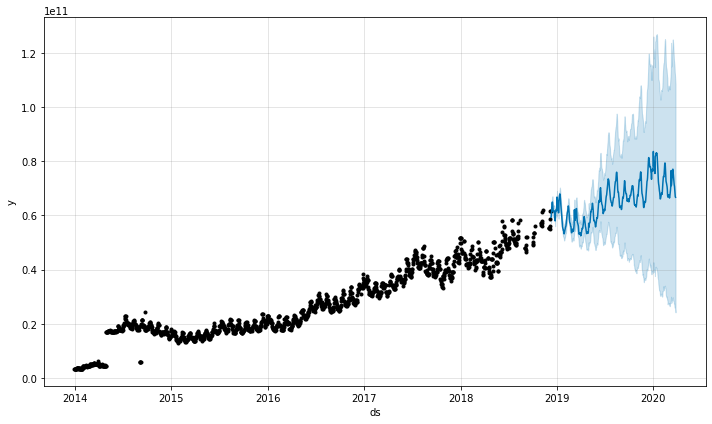

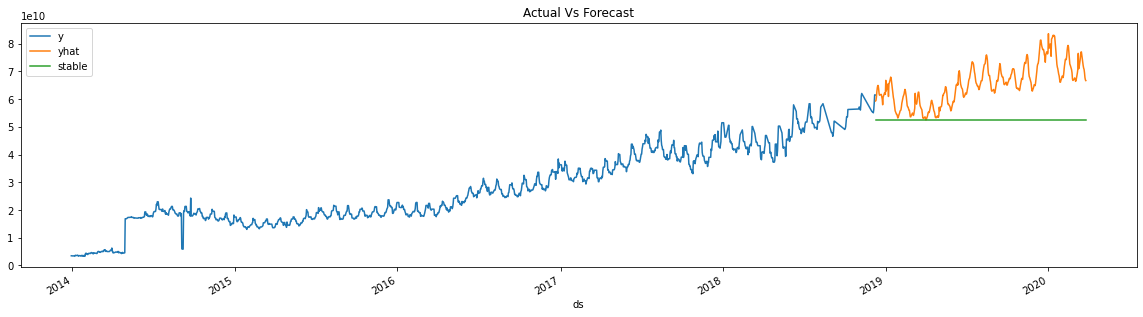

INFO:prophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


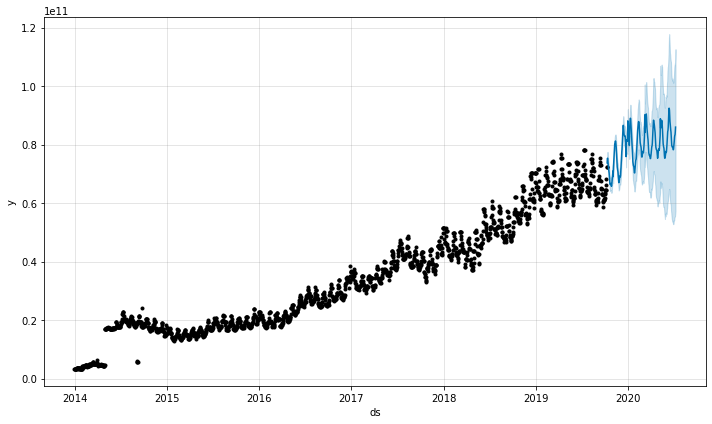

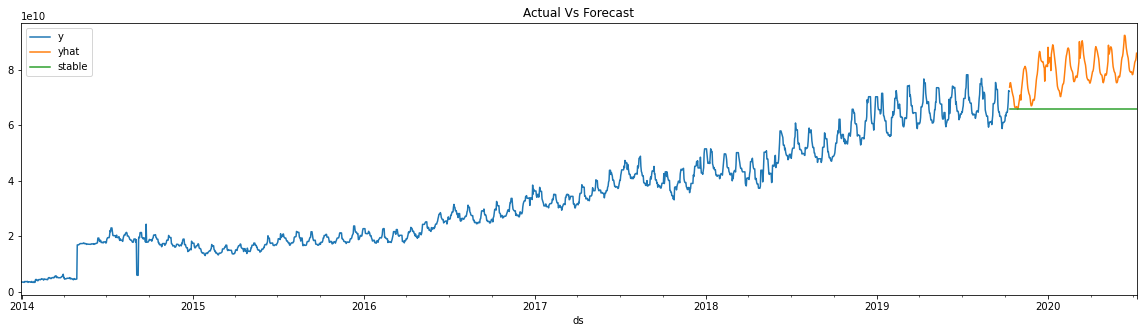

In [109]:
forecast('2018-08-14', '12M', train)
forecast('2019-02-01', '1M', data)